# Two Masses + Three Springs: Physics + Manim Lesson


**Goal:** build intuition for coupled oscillators and practice Python tooling:

- **Physics:** derive and solve the equations of motion (EOM) for two masses connected by three springs (fixed walls at the ends, no damping/friction).
- **Numerics:** integrate the EOM using **NumPy**/**SciPy** (`solve_ivp`) from the **matrix form**.
- **Software design:** store parameters and the numerical solution in a **`@dataclass`**, then **pass** that to a **Manim** scene.
- **Visualization:** animate masses, springs, and walls using **Manim Community**.

---

## Learning objectives

### Physics
1. Write the coupled EOM for two masses with three springs and show the **matrix form**
$$ 
M\,\ddot{\boldsymbol{x}} + K\,\boldsymbol{x} = 0, \quad
      M = \begin{bmatrix} m_1 & 0 \\ 0 & m_2 \end{bmatrix},
      \quad
      K = \begin{bmatrix} k_1 + k_2 & -k_2 \\ -k_2 & k_2 + k_3 \end{bmatrix}.
$$
2. Check **normal modes** and **energy** conservation (no damping).
3. Relate parameters (masses/spring constants) to observed motion (beats, in/out-of-phase modes).

### Python & Software
1. Use `numpy` and `scipy.integrate.solve_ivp` to integrate a **first-order** system built from the matrix EOM.
2. Encapsulate configuration and results in `@dataclass` objects.
3. Clean **API boundary**: put physics & solution in a module (`system_data.py`) that a Manim scene reads.
4. Build a **Manim** scene (Community library) that animates the solution with updaters.

---

## Setup & Dependencies

- Python 3.10+ recommended
- `numpy`, `scipy`, `matplotlib` (for quick checks)
- **Manim Community** (e.g. `pip install manim`)
- (Optional) `ffmpeg` for video export

> Rendering is done from the command line, not inside the notebook:
>
> ```bash
> manim -pql two_masses_scene.py CoupledMassesScene
> ```

---

## Model: Two masses and three springs

We label **displacements** from equilibrium as \(x_1(t)\) and \(x_2(t)\). With fixed walls, the linear EOM are:
$$
\begin{aligned}
m_1 \ddot x_1 &= - (k_1 + k_2) x_1 + k_2 x_2, \\
m_2 \ddot x_2 &= \phantom{-}k_2 x_1 - (k_2 + k_3) x_2.
\end{aligned}
$$
Matrix form:
$$
M\,\ddot{\boldsymbol{x}} + K\,\boldsymbol{x} = 0,\quad
\boldsymbol{x} = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}.
$$
We solve numerically by converting to first-order form for `solve_ivp`:
$$
\frac{d}{dt} \begin{bmatrix} \boldsymbol{x} \\ \dot{\boldsymbol{x}} \end{bmatrix}
=
\begin{bmatrix}
\dot{\boldsymbol{x}} \\
- M^{-1} K \boldsymbol{x}
\end{bmatrix}.
$$


In [1]:

from dataclasses import dataclass
from typing import Dict, Tuple
import numpy as np
from numpy.typing import NDArray
from scipy.integrate import solve_ivp
from scipy.linalg import eigh

@dataclass
class CoupledParams:
    m1: float = 1.0
    m2: float = 1.0
    k1: float = 1.0
    k2: float = 1.0
    k3: float = 1.0
    x10: float = 0.5   # initial displacement of mass 1
    x20: float = -0.3  # initial displacement of mass 2
    v10: float = 0.0   # initial velocity of mass 1
    v20: float = 0.0   # initial velocity of mass 2
    t_max: float = 30.0
    dt: float = 0.01

@dataclass
class CoupledSolution:
    params: CoupledParams
    t: NDArray[np.float64]          # shape (N,)
    x: NDArray[np.float64]          # shape (2, N) -> [x1(t), x2(t)]
    v: NDArray[np.float64]          # shape (2, N) -> [v1(t), v2(t)]
    energies: Dict[str, NDArray[np.float64]]  # 'T','V','E'
    normal_modes: Dict[str, NDArray[np.float64]]  # 'omega' (2,), 'vecs' (2,2)

def build_matrices(p: CoupledParams) -> Tuple[np.ndarray, np.ndarray]:
    M = np.array([[p.m1, 0.0],
                  [0.0, p.m2]], 
                    dtype=float)
    K = np.array([[p.k1 + p.k2, -p.k2],
                  [-p.k2, p.k2 + p.k3]], dtype=float)
    return M, K

def dy_dt(t: float, y: np.ndarray, MinvK: np.ndarray) -> np.ndarray:
    # y = [x1, x2, v1, v2]
    x = y[:2]
    v = y[2:]
    ax = -MinvK @ x
    return np.hstack([v, ax])

def solve_coupled(p: CoupledParams) -> CoupledSolution:
    M, K = build_matrices(p)

    # --- Normal modes: generalized eigenproblem K u = w^2 M u ---
    w2, vecs = eigh(K, M)             # <- robust even when m1 != m2
    omega = np.sqrt(w2)

    print(f"Normal mode frequencies (rad/s): {omega}")

    # First-order system: y = [x1, x2, v1, v2]
    MinvK = np.linalg.inv(M) @ K
    first_order_rhs = lambda t, y: dy_dt(t, y, MinvK)


    y0 = np.array([p.x10, p.x20, p.v10, p.v20], dtype=float)
    t_eval = np.arange(0.0, p.t_max + p.dt/2, p.dt)

    sol = solve_ivp(first_order_rhs, (0.0, p.t_max), y0,
                    t_eval=t_eval, rtol=1e-9, atol=1e-9)
    if not sol.success:
        raise RuntimeError(f"solve_ivp failed: {sol.message}")

    x = sol.y[0:2, :]    # (2, N)
    v = sol.y[2:4, :]

    # --- Energies ---
    # Kinetic: T_k = 0.5 * v(:,k)^T M v(:,k)
    T = 0.5 * np.einsum('ik,ij,jk->k', v, M, v)

    # Potential: V_k = 0.5 * x(:,k)^T K x(:,k)
    V = 0.5 * np.einsum('ik,ij,jk->k', x, K, x)

    E = T + V

    return CoupledSolution(
        params=p,
        t=sol.t,
        x=x,
        v=v,
        energies={'T': T, 'V': V, 'E': E},
        normal_modes={'omega': omega, 'vecs': vecs}
    )
# Default parameters; feel free to tweak and re-run this cell.
params = CoupledParams()
solution = solve_coupled(params)

print("Normal mode frequencies (rad/s):", solution.normal_modes['omega'])
print("Energy drift (abs max - min):", float(np.max(solution.energies['E']) - np.min(solution.energies['E'])))


Normal mode frequencies (rad/s): [1.         1.73205081]
Normal mode frequencies (rad/s): [1.         1.73205081]
Energy drift (abs max - min): 3.3546707411957755e-08


In [2]:
def solve_coupled(p: CoupledParams) -> CoupledSolution:
    M, K = build_matrices(p)

    # Generalized eigenproblem: K u = w^2 M u
    w2, U = eigh(K, M)                       # columns of U = mode shapes
    w2 = np.maximum(w2, 0.0)
    omega = np.sqrt(w2)

    # M-orthonormalize eigenvectors so that U^T M U = I
    # (eigh(K,M) already returns M-orthonormal vectors for well-conditioned problems,
    # but we enforce it explicitly to minimize roundoff)
    MU = M @ U
    for i in range(U.shape[1]):
        norm2 = U[:, i].T @ MU[:, i]         # u_i^T M u_i
        U[:, i] /= np.sqrt(norm2 + 0.0)

    # Initial conditions
    x0 = np.array([p.x10, p.x20], dtype=float)
    v0 = np.array([p.v10, p.v20], dtype=float)

    # Modal coordinates: q = U^T M x, qdot = U^T M v
    q0    = U.T @ (M @ x0)
    qdot0 = U.T @ (M @ v0)

    # Time grid
    t = np.arange(0.0, p.t_max + p.dt/2, p.dt)

    # Build q(t) and qdot(t) exactly for each mode, then map back x=U q, v=U qdot
    coswt = np.cos(np.outer(omega, t))       # (2, N)
    sinwt = np.sin(np.outer(omega, t))       # (2, N)

    # Handle any zero-frequency modes (shouldn't exist here, but be safe)
    with np.errstate(divide='ignore', invalid='ignore'):
        q_t     = q0[:, None] * coswt + np.where(omega[:, None] > 0,
                                                 (qdot0 / omega)[:, None] * sinwt,
                                                 q0[:, None] + qdot0[:, None] * t)
        qdot_t  = - (omega[:, None] * q0[:, None]) * sinwt + \
                  np.where(omega[:, None] > 0,
                           qdot0[:, None] * coswt,
                           qdot0[:, None])

    x = (U @ q_t)         # (2, N)
    v = (U @ qdot_t)      # (2, N)

    # Energies: T = 1/2 v^T M v,  V = 1/2 x^T K x  (per time sample)
    T = 0.5 * np.einsum('ik,ij,jk->k', v, M, v)
    V = 0.5 * np.einsum('ik,ij,jk->k', x, K, x)
    E = T + V

    return CoupledSolution(
        params=p, t=t, x=x, v=v,
        energies={'T': T, 'V': V, 'E': E},
        normal_modes={'omega': omega, 'vecs': U}
    )

params = CoupledParams()
solution = solve_coupled(params)

print("Normal mode frequencies (rad/s):", solution.normal_modes['omega'])
print("Energy drift (abs max - min):", float(np.max(solution.energies['E']) - np.min(solution.energies['E'])))

Normal mode frequencies (rad/s): [1.         1.73205081]
Energy drift (abs max - min): 3.885780586188048e-16


### Quick checks: displacements and energy conservation

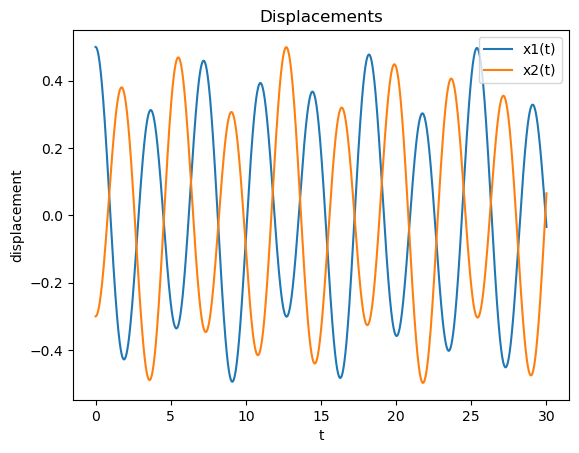

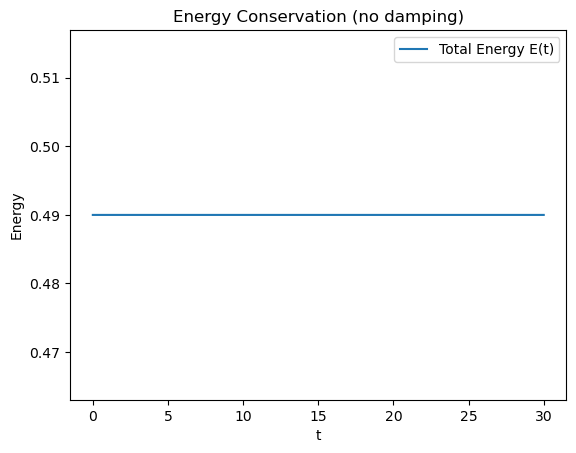

In [3]:

import matplotlib.pyplot as plt

t = solution.t
x1, x2 = solution.x
E = solution.energies['E']

plt.figure()
plt.plot(t, x1, label="x1(t)")
plt.plot(t, x2, label="x2(t)")
plt.xlabel("t")
plt.ylabel("displacement")
plt.legend()
plt.title("Displacements")

plt.figure()
plt.plot(t, E, label="Total Energy E(t)")
plt.xlabel("t")
plt.ylabel("Energy")
plt.legend()
plt.title("Energy Conservation (no damping)")

plt.show()


## Manim scene file: `two_masses_scene.py`


This scene:

- Imports `SYSTEM` from `system_data.py`
- Draws walls, springs, and two masses (horizontal layout)
- Uses a `ValueTracker` to sweep through the precomputed solution
- Assumes displacements are from equilibrium (here set to \(x_1^{(eq)}=-2\), \(x_2^{(eq)}=+2\))



## Exercises / prompts to ask during class

- **Matrix thinking:** where do the diagonal and off-diagonal terms in \(K\) come from physically?
- **Normal modes:** verify one initial condition excites only the lower-frequency mode. What eigenvector is that?
- **Parameter sweep:** what happens to frequencies if \(k_2 \to 0\)? If \(k_2 \gg k_1,k_3\)?
- **Numerics:** how do `rtol/atol` affect energy drift?
- **API design:** what else belongs in the dataclass if we were to extend this to damping or driving?


Your job is to add a manim scene that renders the above solution. Adapt from the CoupledMasses.py.
- Pull in the code for drawing springs
- Update the manim scene to get the solution info from the CoupledSolution object
- Create a subclass that initializes the system in the first/second normal mode.
- BONUS: setup for 3 masses, 4 springs...